### Import packages

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import os
import requests
from io import StringIO
import pymc as pm
import arviz as az
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr, t
import scipy.stats as stats
from scipy.stats import wilcoxon
import statsmodels.stats.multitest as smm
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro, spearmanr
import statsmodels.api as sm

In [19]:
wald_prior_class = "log_normal_prior_centered"

### Import data

In [20]:
try:
    df_processed_experiment_data = pd.read_csv(
        "../data_preprocessing/processed_data/processed_reproduction_task_data.csv"
    )
    print("Successfully loaded processed_reproduction_task_data.csv")
except FileNotFoundError:
    print("File not found. Please run the preprocessing pipeline first to generate 'processed_reproduction_task_data.csv'.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Successfully loaded processed_reproduction_task_data.csv


In [21]:
try:
    df_raw_data = pd.read_csv(
        #"../data_preprocessing/processed_data/processed_reproduction_task_data.csv"
        "../data_preprocessing/processed_data/processed_experiment_data.csv"
    )
    print("Successfully loaded all data (including outliers)")
except FileNotFoundError:
    print("File not found. Please run the preprocessing pipeline first to generate 'processed_experiment_data.csv'.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Successfully loaded all data (including outliers)


In [22]:
df_analysis = df_processed_experiment_data[df_processed_experiment_data["MissedMaxDeadline"]==0]

print("Percentage of data used for reproduction time analysis: "+str((100*len(df_analysis))/len(df_raw_data))+" %")

Percentage of data used for reproduction time analysis: 97.31343283582089 %


### Import fitted parameters

In [23]:
df_wald_fitted_params = pd.read_csv(f'../model_fitting/fitted_parameters/wald/indi_fitted_params_wald_{wald_prior_class}.csv')

par_ids = np.unique(df_wald_fitted_params['Participant_ID'])

n_par = len(par_ids)

### Import ddm fitted parameters
df_ddm_fitted_params = pd.read_csv('../model_fitting/fitted_parameters/ddm/fitted_parameters_ddm.csv')

idata_wald = az.from_netcdf(f"../model_fitting/idata_wald_{wald_prior_class}.nc")

wald_post = idata_wald.posterior

### Import LME slope data

In [24]:
df_slopes = pd.read_csv(f'../data_analysis/participant_TT_slopes.csv')

### Helper functions

In [25]:
def standard_error(data):
    """
    Calculate the standard error of the mean (SEM) for a list or NumPy array.

    Parameters
    ----------
    data : list or np.ndarray
        The numeric data values.

    Returns
    -------
    float
        The standard error of the mean.
    """
    data = np.array(data)
    n = len(data)
    if n < 2:
        raise ValueError("Need at least two data points to compute SEM.")
    return np.std(data, ddof=1) / np.sqrt(n)


In [26]:
def normality_report(x, name="sample", alpha=0.05, make_plots=True):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]  # drop NaNs if any

    print(f"\n=== {name} ===")
    print(f"n = {len(x)}")

    if len(x) < 3:
        print("Not enough data to assess normality (need at least 3 points).")
        return

    # --- Shapiro–Wilk ---
    W, p_shapiro = stats.shapiro(x)
    print(f"Shapiro–Wilk: W={W:.4f}, p={p_shapiro:.4g} -> "
          f"{'reject' if p_shapiro < alpha else 'fail to reject'} normality (alpha={alpha})")

    # --- D’Agostino–Pearson (needs n >= 8) ---
    if len(x) >= 8:
        K2, p_dag = stats.normaltest(x)
        print(f"D’Agostino–Pearson: K2={K2:.4f}, p={p_dag:.4g} -> "
              f"{'reject' if p_dag < alpha else 'fail to reject'} normality (alpha={alpha})")
    else:
        print("D’Agostino–Pearson: skipped (needs n >= 8).")

    # --- Anderson–Darling ---
    ad = stats.anderson(x, dist='norm')
    # Find the critical value corresponding to ~alpha if available
    crit = dict(zip(ad.significance_level, ad.critical_values))
    closest_level = min(crit.keys(), key=lambda lvl: abs(lvl - alpha*100))
    reject_ad = ad.statistic > crit[closest_level]
    print(f"Anderson–Darling: A2={ad.statistic:.4f}. "
          f"At ~{closest_level}% level: critical={crit[closest_level]:.4f} -> "
          f"{'reject' if reject_ad else 'fail to reject'} normality")

    if make_plots:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Histogram
        axes[0].hist(x, bins="auto", density=True)
        mu, sigma = x.mean(), x.std(ddof=1)
        xs = np.linspace(x.min(), x.max(), 200)
        axes[0].plot(xs, stats.norm.pdf(xs, mu, sigma))
        axes[0].set_title(f"{name}: histogram + fitted normal")
        
        # Q–Q plot
        stats.probplot(x, dist="norm", plot=axes[1])
        axes[1].set_title(f"{name}: Q–Q plot")

        plt.tight_layout()
        plt.show()

### Compute quantities for analysis

In [27]:
# Quantities of interest
mean_objective_target_time = np.zeros(n_par)
mean_rts = np.zeros(n_par)
IQR_rts = np.zeros(n_par)
IQR_repro_ts = np.zeros(n_par)

# Estimated parameters or quantities derived from estimated parameters
drift_params = np.zeros(n_par) 
beta_0_params = np.zeros(n_par) 
beta_1_params = np.zeros(n_par) 
beta_2_params = np.zeros(n_par) 
a_params = np.zeros(n_par)
delta_beta1_minus_beta2_prime = np.zeros(n_par)
beta0_prime_params = np.zeros(n_par)


for p, par in enumerate(par_ids):
    df_par_experiment_data = df_analysis[df_analysis['ParticipantID']==par]
    df_par_raw_data = df_raw_data[df_raw_data['ParticipantID']==par]

    # Get estimated parameters
    df_par_wald = df_wald_fitted_params[df_wald_fitted_params['Participant_ID']==par]
    df_par_ddm = df_ddm_fitted_params[df_ddm_fitted_params['ParticipantID']==par]
    
    a_params[p] = df_par_ddm['fitted_a_mean'].iloc[0]
    drift_params[p] = df_par_wald['indi_drift_mean'].iloc[0]
    beta_0 = df_par_wald['indi_beta0_mean'].iloc[0]
    beta_1 = df_par_wald['indi_beta1_mean'].iloc[0]
    beta_2 = df_par_wald['indi_beta2_mean'].iloc[0]
    
    beta_0_params[p] = beta_0
    beta_1_params[p] = beta_1
    beta_2_params[p] = beta_2

    # Get normalized parameters
    beta0_prime_params[p] = beta_0/(beta_0+beta_1+beta_2)
    delta_beta1_minus_beta2_prime[p] = (beta_1 - beta_2)/(beta_0+beta_1+beta_2)

    # Get behavioural data
    mean_objective_target_time[p] = np.mean(df_par_raw_data['GambleFinalDeadline'])
    mean_rts[p] = np.mean(df_par_raw_data['ResponseTimeGamble'])
    IQR_rts[p] = df_par_raw_data['ResponseTimeGamble'].quantile(0.75) - df_par_raw_data['ResponseTimeGamble'].quantile(0.25)
    IQR_repro_ts[p] = df_par_experiment_data['ReproducedTime'].quantile(0.75) - df_par_experiment_data['ReproducedTime'].quantile(0.25)

### Classify participants

In [28]:
# 1) Posterior for the difference (beta1 - beta2) for each subject
diff = wald_post["indi_beta1"] - wald_post["indi_beta2"]   # dims: chain, draw, subject

# 2) Probability that (beta1 - beta2) < 0 for each subject
prob_below_zero = (diff < 0).mean(dim=("chain", "draw"))

prob_above_zero = (diff > 0).mean(dim=("chain", "draw"))
# prob_below_zero is a DataArray with dim "subject"


mask_negative = prob_below_zero > 0.95

mask_positive = prob_above_zero > 0.95

# Subjects that satisfy the criterion
par_ids_negative_delta_par = prob_below_zero["subject"].values[mask_negative.values]

par_ids_positive_delta_par = prob_above_zero["subject"].values[mask_positive.values]

par_ids_low_delta_par = []

for par in par_ids:
    if par not in par_ids_negative_delta_par and par not in par_ids_positive_delta_par:
        par_ids_low_delta_par.append(par)

# Analysis

### Parameter estimates ranges

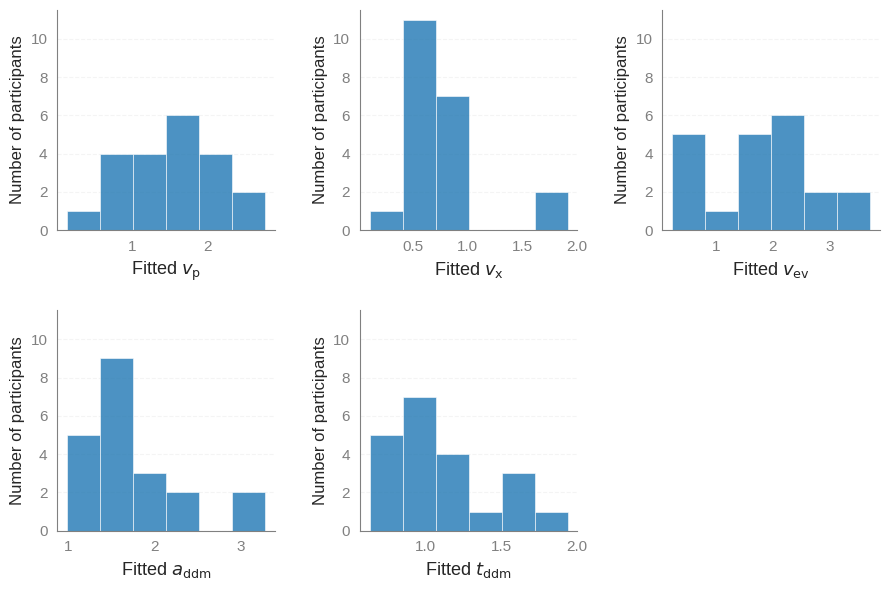

In [29]:
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
})

# --- Data and labels ---
plots = [
    (df_ddm_fitted_params['fitted_d_p_mean'].values, r"Fitted $v_{\mathrm{p}}$",   "C0"),
    (df_ddm_fitted_params['fitted_d_x_mean'].values, r"Fitted $v_{\mathrm{x}}$",   "C0"),
    (df_ddm_fitted_params['fitted_d_ev_mean'].values, r"Fitted $v_{\mathrm{ev}}$", "C0"),
    (df_ddm_fitted_params['fitted_a_mean'].values,   r"Fitted $a_{\mathrm{ddm}}$", "C0"),
    (df_ddm_fitted_params['fitted_t_mean'].values,   r"Fitted $t_{\mathrm{ddm}}$", "C0"),
]

# --- Create 2x3 grid (6 slots, one will stay empty) ---
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharey=False)
axes = axes.flatten()

# --- Loop through available plots ---
for ax, (vals, xlabel, color) in zip(axes, plots):
    vals = vals[np.isfinite(vals)]
    bins = 6  # fixed number of bins

    ax.hist(
        vals, bins=bins, color=color, alpha=0.8,
        edgecolor="white", linewidth=0.5
    )
    ax.set_ylim(0, 11.5)
    # Labels
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel("Number of participants", fontsize=12)

    # Styling: clean and consistent
    for spine in ax.spines.values():
        spine.set_color("gray")
        spine.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=11, colors="gray")
    sns.despine(ax=ax, top=True, right=True)
    ax.grid(axis="y", alpha=0.2, linestyle="--")

# --- Remove the last empty subplot (6th slot) ---
if len(plots) < len(axes):
    for j in range(len(plots), len(axes)):
        fig.delaxes(axes[j])

# --- Adjust spacing ---
plt.tight_layout(h_pad=2, w_pad=2)

# --- Save and show ---
#plt.savefig('../figures/fitted_ddm_params.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [12]:
print("Minimum estimated non-decision time for the DDM: "+str(min(df_ddm_fitted_params['fitted_t_mean'].values)))
print("Maximum estimated non-decision time for the DDM: "+str(max(df_ddm_fitted_params['fitted_t_mean'].values)))

Minimum estimated non-decision time for the DDM: 0.634
Maximum estimated non-decision time for the DDM: 1.937


## Some statistics

In [13]:
rt = df_raw_data['ResponseTimeGamble']

pct_below_10 = (rt < 10).mean() * 100
print("% of trials (raw data) where the RT is below 10 s : " +str(pct_below_10))


% of trials (raw data) where the RT is below 10 s : 98.8955223880597


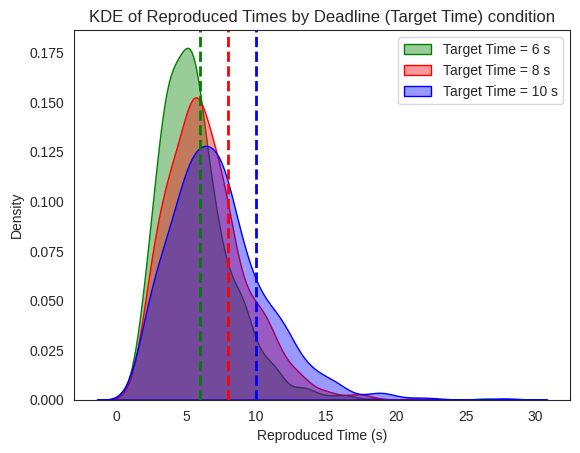

In [14]:
# Filtered data subsets
df_experiment_deadline_6 = df_processed_experiment_data[
    (df_processed_experiment_data['GambleFinalDeadline'] == 6) &
    (df_processed_experiment_data['MissedMaxDeadline'] == 0)
]

df_experiment_deadline_8 = df_processed_experiment_data[
    (df_processed_experiment_data['GambleFinalDeadline'] == 8) &
    (df_processed_experiment_data['MissedMaxDeadline'] == 0)
]

df_experiment_deadline_10 = df_processed_experiment_data[
    (df_processed_experiment_data['GambleFinalDeadline'] == 10) &
    (df_processed_experiment_data['MissedMaxDeadline'] == 0)
]

# KDE plots
sns.kdeplot(df_experiment_deadline_6['ReproducedTime'], color="green", fill=True, alpha=0.4, label='Target Time = 6 s')
sns.kdeplot(df_experiment_deadline_8['ReproducedTime'], color="red", fill=True, alpha=0.4, label='Target Time = 8 s')
sns.kdeplot(df_experiment_deadline_10['ReproducedTime'], color="blue", fill=True, alpha=0.4, label='Target Time = 10 s')

# Vertical lines for deadlines
plt.axvline(x=6, color="green", linestyle='--', linewidth=2)
plt.axvline(x=8, color="red", linestyle='--', linewidth=2)
plt.axvline(x=10, color="blue", linestyle='--', linewidth=2)

# Labels and legend
plt.xlabel("Reproduced Time (s)")
plt.ylabel("Density")
plt.title("KDE of Reproduced Times by Deadline (Target Time) condition")
plt.legend()
plt.show()


## Parameter interpretation

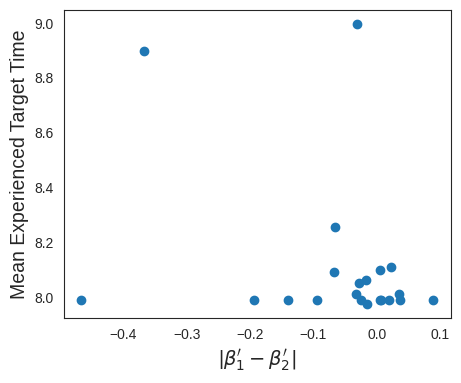

In [15]:
plt.figure(figsize=(5, 4)) 
plt.scatter(delta_beta1_minus_beta2_prime,mean_objective_target_time)
plt.ylabel("Mean Experienced Target Time", fontsize = 14)
plt.xlabel(r"|$\beta_{1}^{\prime}-\beta_{2}^{\prime}|$", fontsize = 14)
plt.show()

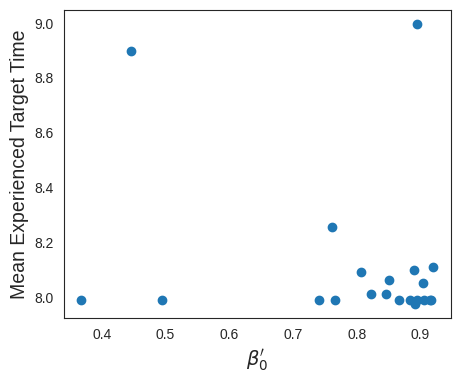

In [16]:
plt.figure(figsize=(5, 4)) 
plt.scatter(beta0_prime_params,mean_objective_target_time)
plt.ylabel("Mean Experienced Target Time", fontsize = 14)
plt.xlabel(r"$\beta_{0}^{\prime}$", fontsize = 14)
plt.show()

Pearson r = 0.107, p-value = 0.6430


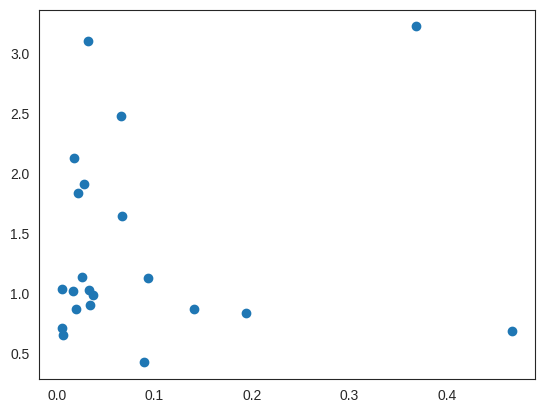

In [17]:
plt.scatter(abs(delta_beta1_minus_beta2_prime),IQR_rts)
r, p = pearsonr(abs(delta_beta1_minus_beta2_prime), IQR_rts)
print(f"Pearson r = {r:.3f}, p-value = {p:.4f}")

In [54]:
rmse = np.zeros(n_par)
average_repro = np.zeros(n_par)
std_repro_t = np.zeros(n_par)
slope = np.zeros(n_par)
median_rt = np.zeros(n_par)
iqr = np.zeros(n_par)
r_DJR_log_rt = np.zeros(n_par)

for p, par in enumerate(par_ids):
    
    df_par_deadline_6 = df_processed_experiment_data[(df_processed_experiment_data['ParticipantID'] == par) & 
                           (df_processed_experiment_data['MissedMaxDeadline'] == 0) & 
                           (df_processed_experiment_data['GambleFinalDeadline'] == 6)]
    
    df_par_deadline_8 = df_processed_experiment_data[(df_processed_experiment_data['ParticipantID'] == par) & 
                           (df_processed_experiment_data['MissedMaxDeadline'] == 0) & 
                           (df_processed_experiment_data['GambleFinalDeadline'] == 8)]
    
    df_par_deadline_10 = df_processed_experiment_data[(df_processed_experiment_data['ParticipantID'] == par) & 
                           (df_processed_experiment_data['MissedMaxDeadline'] == 0) & 
                           (df_processed_experiment_data['GambleFinalDeadline'] == 10)]
    
    df_par= df_processed_experiment_data[(df_processed_experiment_data['ParticipantID'] == par) & 
                           (df_processed_experiment_data['MissedMaxDeadline'] == 0)]
    
    mean_repro_deadline_6 = np.mean(df_par_deadline_6['ReproducedTime'])
    mean_repro_deadline_8 = np.mean(df_par_deadline_8['ReproducedTime'])
    mean_repro_deadline_10 = np.mean(df_par_deadline_10['ReproducedTime'])
    
    mean_repro = np.mean([mean_repro_deadline_6,mean_repro_deadline_8,mean_repro_deadline_10])
    
    rmse[p] = np.sqrt(((mean_repro_deadline_6-mean_repro)**2 + (mean_repro_deadline_8-mean_repro)**2 + (mean_repro_deadline_10-mean_repro)**2)/3)
    average_repro[p] =  np.mean(df_par['ReproducedTime'])
    std_repro_t[p] = np.std(df_par['ReproducedTime'])

    # Calculate interquartile range of reproduced times
    q1 = np.percentile(df_par['ReproducedTime'], 25)  # First quartile (Q1)
    q3 = np.percentile(df_par['ReproducedTime'], 75)  # Third quartile (Q3)
    iqr[p] = q3-q1 

    X = np.array([6,8,10])  # Independent variable (input)
    y = np.array([mean_repro_deadline_6,mean_repro_deadline_8,mean_repro_deadline_10])  # Dependent variable (output)

    # Step 3: Reshape X if necessary (sklearn expects 2D array for features)
    X = X.reshape(-1, 1)  # Converts X to a 2D array with one column

    # Step 4: Initialize the Linear Regression model
    model = LinearRegression()

    # Step 5: Fit the model to the data
    model.fit(X, y)

    # Step 6: Get the slope (coefficient) and intercept of the line
    slope[p] = model.coef_[0]
    median_rt[p] = np.median(df_par['ResponseTimeGamble'])

    df_par_rt_less_than_6 = df_processed_experiment_data[(df_processed_experiment_data['ParticipantID'] == par) & 
                           (df_processed_experiment_data['MissedMaxDeadline'] == 0) & 
                           (df_processed_experiment_data['ResponseTimeGamble'] <= 10)]
    
    
    djrs = df_par_rt_less_than_6['ReproducedTime']/df_par_rt_less_than_6['GambleFinalDeadline']
    
    log_rts = np.log(df_par_rt_less_than_6['ResponseTimeGamble'])
    
    r_DJR_log_rt[p], pval_r_DJR_log_rt = pearsonr(djrs, log_rts)

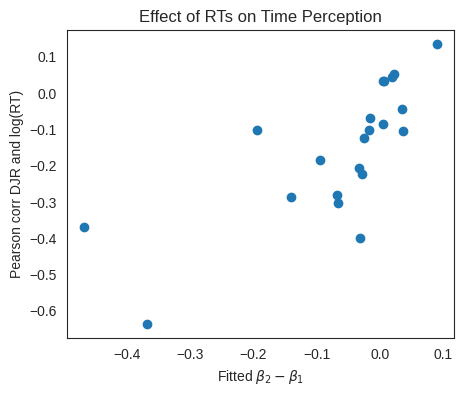

In [19]:
plt.figure(figsize=(5, 4)) 
plt.scatter(delta_beta1_minus_beta2_prime,r_DJR_log_rt)
plt.title(r"Effect of RTs on Time Perception", fontsize = 12)
plt.ylabel("Pearson corr DJR and log(RT)", fontsize = 10)
plt.xlabel(r"Fitted $\beta_{2} - \beta_{1}$", fontsize = 10)
plt.show()


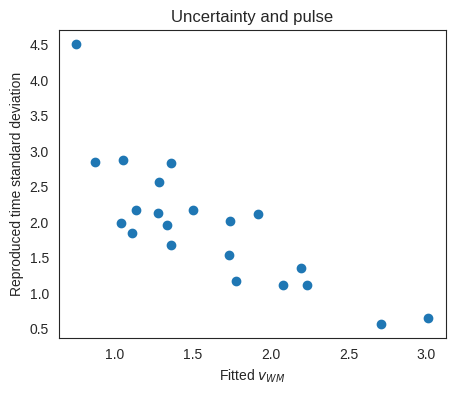

In [20]:
plt.figure(figsize=(5, 4)) 
plt.scatter(drift_params,std_repro_t)
plt.title(r"Uncertainty and pulse", fontsize = 12)
plt.ylabel("Reproduced time standard deviation", fontsize = 10)
plt.xlabel(r"Fitted $v_{WM}$", fontsize = 10)
plt.show()


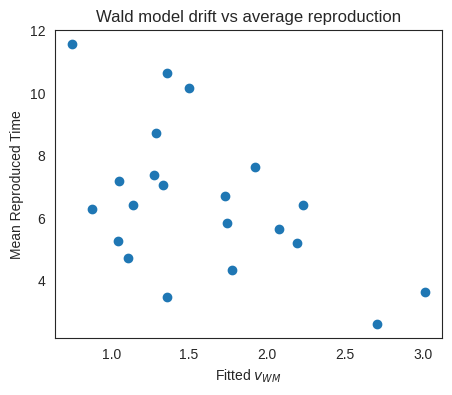

In [21]:
plt.figure(figsize=(5, 4)) 
plt.scatter(drift_params,average_repro)
plt.title(r"Wald model drift vs average reproduction", fontsize = 12)
plt.ylabel("Mean Reproduced Time", fontsize = 10)
plt.xlabel(r"Fitted $v_{WM}$", fontsize = 10)
plt.show()

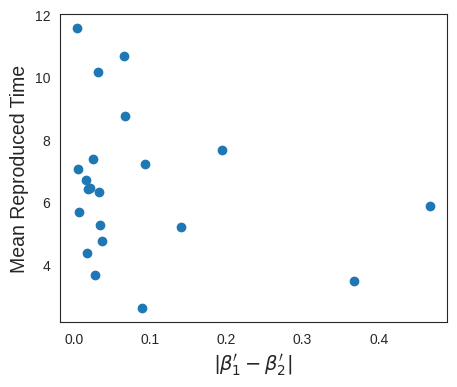

In [22]:
plt.figure(figsize=(5, 4)) 
plt.scatter(abs(delta_beta1_minus_beta2_prime),average_repro)

plt.ylabel("Mean Reproduced Time", fontsize = 14)
plt.xlabel(r"|$\beta_{1}^{\prime}-\beta_{2}^{\prime}|$", fontsize = 14)
plt.show()

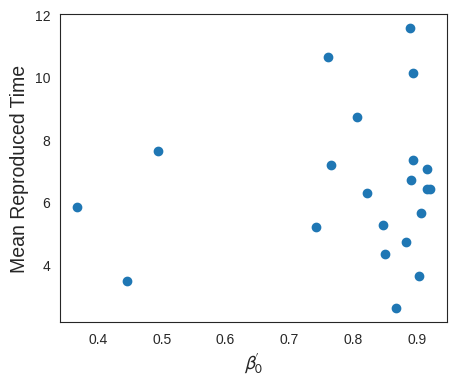

Pearson r = 0.117, p = 0.613


In [57]:
plt.figure(figsize=(5, 4)) 
plt.scatter(beta0_prime_params,average_repro)

plt.ylabel("Mean Reproduced Time", fontsize = 14)
plt.xlabel(r"$\beta_{0}^{\prime}$", fontsize = 14)
plt.show()

r, p = pearsonr(beta0_prime_params, average_repro)
print(f"Pearson r = {r:.3f}, p = {p:.3g}")

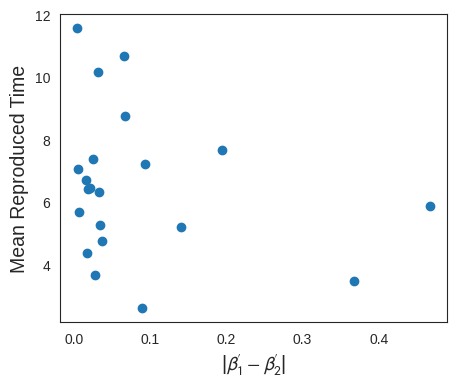

Pearson correlation: -0.237
P-value: 0.301


In [60]:
plt.figure(figsize=(5, 4)) 
plt.scatter(abs(delta_beta1_minus_beta2_prime),average_repro)

plt.ylabel("Mean Reproduced Time", fontsize = 14)
plt.xlabel(r"|$\beta_{1}^{\prime}-\beta_{2}^{\prime}$|", fontsize = 14)
plt.show()

corr, p_value = pearsonr(abs(delta_beta1_minus_beta2_prime), average_repro)

print(f"Pearson correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

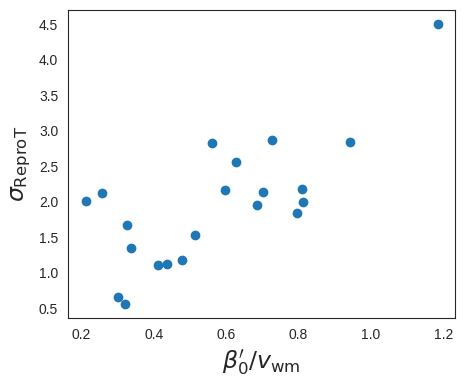

In [24]:
plt.figure(figsize=(5, 4)) 
plt.scatter(beta0_prime_params/drift_params,std_repro_t)

plt.ylabel(r"$\sigma_{\text{ReproT}}$", fontsize = 17)
plt.xlabel(r"$\beta_{0}^{\prime}/v_{\text{wm}}$", fontsize = 17)
plt.show()

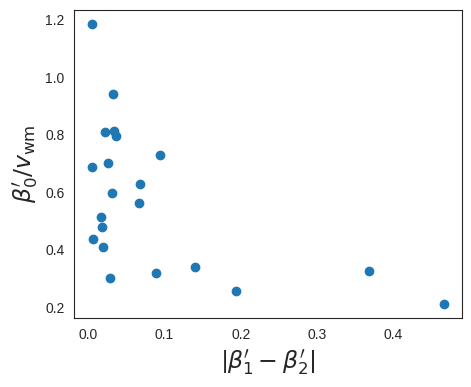

In [25]:
plt.figure(figsize=(5, 4)) 
plt.scatter(abs(delta_beta1_minus_beta2_prime), beta0_prime_params/drift_params)

plt.xlabel(r"|$\beta_{1}^{\prime}-\beta_{2}^{\prime}|$", fontsize = 17)
plt.ylabel(r"$\beta_{0}^{\prime}/v_{\text{wm}}$", fontsize = 17)
plt.show()

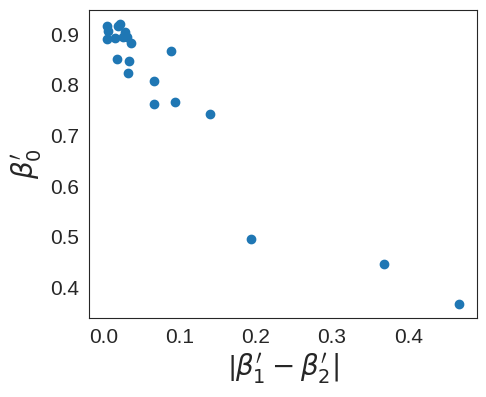

r = -0.952, p = 3.495e-11


In [26]:

fontsize = 20
plt.figure(figsize=(5, 4))

plt.scatter(abs(delta_beta1_minus_beta2_prime), beta0_prime_params)
#plt.title("Plot of Delta beta vs v0_params with Significance Coloring")
plt.xlabel(r"|$\beta_{1}^{\prime}-\beta_{2}^{\prime}|$", fontsize = fontsize)
plt.ylabel(r"$\beta_{0}^{\prime}$", fontsize = fontsize)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

r, p = pearsonr(abs(delta_beta1_minus_beta2_prime), beta0_prime_params)
print(f"r = {r:.3f}, p = {p:.3e}")

#### Relationship between beta_0 and the central tendency bias

Pearson r = -0.887, p = 8.35e-08
Spearman rho = -0.860, p = 5.9e-07
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     70.23
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           8.35e-08
Time:                        13:35:44   Log-Likelihood:                 25.155
No. Observations:                  21   AIC:                            -46.31
Df Residuals:                      19   BIC:                            -44.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

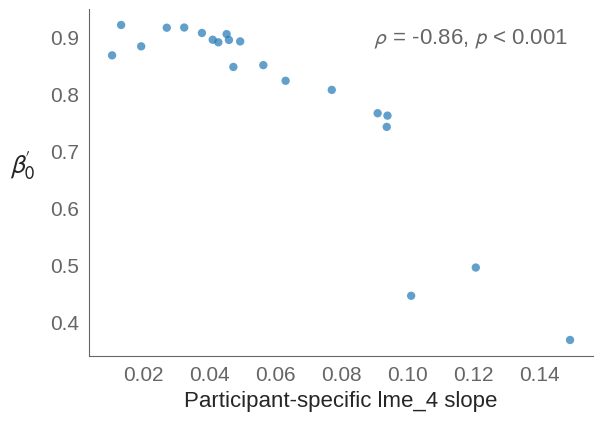

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# --- data ---
x = df_slopes["total_slope_TT"].to_numpy()
y = np.asarray(beta0_prime_params)

# --- style (match your other figures) ---
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

grey = "0.4"
fontsize = 16

# --- correlations ---
r, p_pearson = pearsonr(x, y)
rho, p_spearman = spearmanr(x, y)
print(f"Pearson r = {r:.3f}, p = {p_pearson:.3g}")
print(f"Spearman rho = {rho:.3f}, p = {p_spearman:.3g}")

# --- regression models (centered x, as you had) ---
df = pd.DataFrame({"x": x, "y": y})
df["x_c"] = df["x"] - df["x"].mean()

# Linear: y ~ x_c
X1 = sm.add_constant(df["x_c"])
m1 = sm.OLS(df["y"], X1).fit()

# Quadratic: y ~ x_c + x_c^2
df["x_c2"] = df["x_c"]**2
X2 = sm.add_constant(df[["x_c", "x_c2"]])
m2 = sm.OLS(df["y"], X2).fit()

print(m1.summary())
print(m2.summary())
print("Linear  AIC:", m1.aic, "BIC:", m1.bic)
print("Quad    AIC:", m2.aic, "BIC:", m2.bic)

# --- figure: scatter + linear fit, in your house style ---
fig, ax = plt.subplots(figsize=(6.5, 4.5))

# scatter
ax.scatter(
    x,
    y,
    color="C0",
    alpha=0.7,
    edgecolor="none"
)

# linear fit (on original x scale)
x_grid = np.linspace(x.min(), x.max(), 200)
x_grid_c = x_grid - df["x"].mean()
y_pred = m1.predict(sm.add_constant(x_grid_c))
#ax.plot(x_grid, y_pred, color="C0", linewidth=2)

# vertical line at 0 slope (nice reference)
#ax.axvline(0, color="grey", linestyle="--", linewidth=1.2)

# labels and title
#ax.set_title(r"$\beta_{0}^{\prime}$ and the central-tendency bias", fontsize=fontsize+3)
ax.set_xlabel("Participant-specific lme_4 slope", fontsize=fontsize)
ax.set_ylabel(r"$\beta_{0}^{\prime}$", fontsize=fontsize+3, rotation=0, labelpad=20)

# ticks and spines (match your other figure)
ax.tick_params(axis="both", which="major", labelsize=15, colors=grey)

for spine in ["bottom", "left"]:
    ax.spines[spine].set_color(grey)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

sns.despine(ax=ax)

if p_spearman < 0.001:
    text = rf"$\rho$ = {rho:.2f}, $p$ < 0.001"
else:
    text = rf"$\rho$ = {rho:.2f}, $p$ = {p_spearman:.3g}"
    
ax.text(
    0.95, 0.95,
    text,
    transform=ax.transAxes,
    va="top",
    ha="right",
    fontsize=16,
    color=grey,
)

#plt.tight_layout()
#
# optionally save
outdir_figures = "../figures"
os.makedirs(outdir_figures, exist_ok=True)
out_figure_path = os.path.join(outdir_figures, "beta0_prime_vs_slope.svg")
plt.savefig(out_figure_path, format="svg", bbox_inches="tight")

plt.show()


## Group comparison

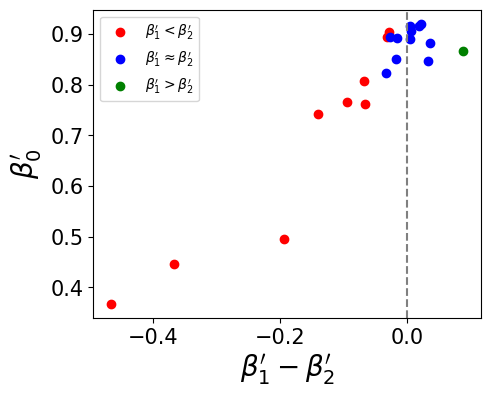

In [11]:

fontsize = 20


plt.figure(figsize=(5, 4))

indices_group_1 = [i for i, item in enumerate(par_ids) if item in par_ids_negative_delta_par]

indices_group_2 = [i for i, item in enumerate(par_ids) 
                   if item not in par_ids_positive_delta_par and item not in par_ids_negative_delta_par]

indices_group_3 = [i for i, item in enumerate(par_ids) if item in par_ids_positive_delta_par]

plt.scatter(delta_beta1_minus_beta2_prime[indices_group_1], beta0_prime_params[indices_group_1], color='red', label=r"$\beta_{1}^{\prime}<\beta_{2}^{\prime}$")
plt.scatter(delta_beta1_minus_beta2_prime[indices_group_2], beta0_prime_params[indices_group_2], color='blue', label=r"$\beta_{1}^{\prime} \approx \beta_{2}^{\prime}$")
plt.scatter(delta_beta1_minus_beta2_prime[indices_group_3], beta0_prime_params[indices_group_3], color='green', label=r"$\beta_{1}^{\prime}>\beta_{2}^{\prime}$")
plt.axvline(0, color='grey', linestyle='--')
#plt.title("Plot of Delta beta vs v0_params with Significance Coloring")
plt.xlabel(r"$\beta_{1}^{\prime}-\beta_{2}^{\prime}$", fontsize = fontsize)
plt.ylabel(r"$\beta_{0}^{\prime}$", fontsize = fontsize)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.legend()

#plt.savefig('../figures/v0_vs_v1_minus_v_2.png', dpi=200, bbox_inches='tight')
plt.show()

/tmp/ipykernel_614/515387018.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([df_processed_experiment_data_group_1['ReproducedTime'],df_processed_experiment_data_group_2['ReproducedTime']], labels=[r"$\beta_{1}^{\prime}<\beta_{2}^{\prime}$ or $\beta_{1}^{\prime}>\beta_{2}^{\prime}$ ",


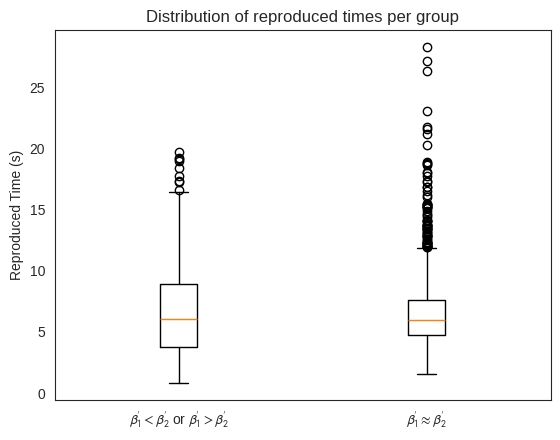

Median ReproT for group beta_1_prime = beta_2_prime : 5.991800000071526
Median ReproT for rest: 6.019799999982118
Median ReproT for group beta_1_prime = beta_2_prime : 5.991800000071526
Mean ReproT for group beta_1_prime = beta_2_prime : 6.5061446198865465
Mean ReproT for rest : 6.541755835962827
IQR ReproT for group beta_1_prime = beta_2_prime : [4.772600000858307-7.6228750000000005] 2.8502749991416936
IQR ReproT for rest : [3.746-8.881800000011921] 5.135800000011921


In [51]:
# group 1: in either list
mask_group_1 = df_processed_experiment_data['ParticipantID'].isin(par_ids_negative_delta_par) | \
               df_processed_experiment_data['ParticipantID'].isin(par_ids_positive_delta_par)

df_processed_experiment_data_group_1 = df_processed_experiment_data[mask_group_1]

# group 2: in neither list
mask_group_2 = ~df_processed_experiment_data['ParticipantID'].isin(par_ids_negative_delta_par) & \
               ~df_processed_experiment_data['ParticipantID'].isin(par_ids_positive_delta_par)

df_processed_experiment_data_group_2 = df_processed_experiment_data[mask_group_2]


fig, ax = plt.subplots()
ax.boxplot([df_processed_experiment_data_group_1['ReproducedTime'],df_processed_experiment_data_group_2['ReproducedTime']], labels=[r"$\beta_{1}^{\prime}<\beta_{2}^{\prime}$ or $\beta_{1}^{\prime}>\beta_{2}^{\prime}$ ", 
                                                                                                                                   r"$\beta_{1}^{\prime} \approx \beta_{2}^{\prime}$"])
ax.set_ylabel('Reproduced Time (s)')
ax.set_title('Distribution of reproduced times per group')
plt.show()


print(r"Median ReproT for group beta_1_prime = beta_2_prime : "+str(np.median(df_processed_experiment_data_group_2['ReproducedTime'])))

print(
    "Median ReproT for rest: "
    + str(np.median(df_processed_experiment_data_group_1['ReproducedTime']))
)

print(r"Median ReproT for group beta_1_prime = beta_2_prime : "+str(np.median(df_processed_experiment_data_group_2['ReproducedTime'])))

print(r"Mean ReproT for group beta_1_prime = beta_2_prime : "+str(np.mean(df_processed_experiment_data_group_2['ReproducedTime'])))
print(r"Mean ReproT for rest : "+str(np.mean(df_processed_experiment_data_group_1['ReproducedTime'])))





x = df_processed_experiment_data_group_2['ReproducedTime']
q1 = x.quantile(0.25)
q3 = x.quantile(0.75)
iqr = q3 - q1



print(r"IQR ReproT for group beta_1_prime = beta_2_prime : ["+str(q1)+"-"+str(q3)+"] " +str(iqr))



x = df_processed_experiment_data_group_1['ReproducedTime']
q1 = x.quantile(0.25)
q3 = x.quantile(0.75)
iqr = q3 - q1

print(r"IQR ReproT for rest : ["+str(q1)+"-"+str(q3)+"] " +str(iqr))

95% HDI for v3: [-0.37053215  0.04154997]


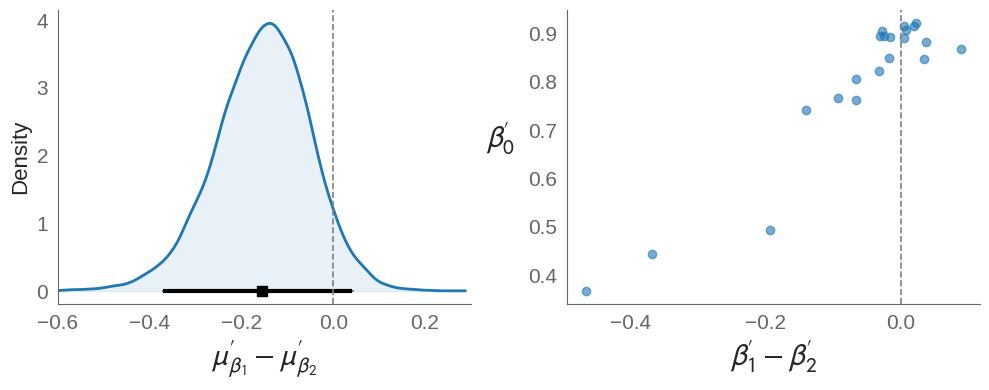

Posterior mass below 0: 0.943 (94.2%)


In [30]:


# --- style ---
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

# --- extract samples ---
v1 = idata_wald.posterior["group_beta1_mu"].stack(sample=("chain", "draw")).values
v2 = idata_wald.posterior["group_beta2_mu"].stack(sample=("chain", "draw")).values
v3 = v1 - v2

mean3 = np.mean(v3)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

grey = "0.4"  # medium grey

# =======================
# LEFT: KDE with HDI
# =======================
ax = axes[0]

az.plot_kde(
    v3,
    ax=ax,
    plot_kwargs={"color": "C0", "lw": 2},
    fill_kwargs={"alpha": 0.10, "color": "C0"},
)

ax.set_xlabel(r"$\mu_{\beta_1}^{\prime} - \mu_{\beta_2}^{\prime}$", fontsize=22)
ax.set_ylabel("Density", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15, colors=grey)

# HDI
hdi_95 = az.hdi(v3, hdi_prob=0.95)
lower, upper = hdi_95
print("95% HDI for v3:", hdi_95)

ax.hlines(y=0, xmin=lower, xmax=upper, colors="k", linewidth=3)
ax.vlines([lower, upper], ymin=0, ymax=0.01, colors="k", linewidth=2)

ax.scatter(mean3, 0, marker="s", color="k", s=60, zorder=5)

ax.axvline(0, color="grey", linestyle="--", linewidth=1.2)

# spines grey
for spine in ["bottom", "left"]:
    ax.spines[spine].set_color(grey)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

sns.despine(ax=ax)
ax.set_xlim(-0.6, 0.3)

# =======================
# RIGHT: scatter plot
# =======================
ax2 = axes[1]

fontsize = 22

ax2.scatter(delta_beta1_minus_beta2_prime, beta0_prime_params, color='C0', alpha=0.6)

ax2.axvline(0, color='grey', linestyle='--', linewidth=1.2)

ax2.set_xlabel(r"$\beta_{1}^{\prime} - \beta_{2}^{\prime}$", fontsize=fontsize)
# bring y-label closer: labelpad smaller
ax2.set_ylabel(r"$\beta_{0}^{\prime}$", fontsize=fontsize, rotation=0, labelpad=20)

# corner style + grey spines
for spine in ["bottom", "left"]:
    ax2.spines[spine].set_color(grey)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.tick_params(axis='both', which='major', labelsize=15, colors=grey)

sns.despine(ax=ax2)

plt.tight_layout()

outdir_figures = "../figures"
os.makedirs(outdir_figures, exist_ok=True)
out_figure_path = os.path.join(
    outdir_figures,
    f"group_and_indi_beta1_beta2_wald_{wald_prior_class}.svg"
)

#plt.savefig(out_figure_path, format="svg", bbox_inches="tight")
plt.show()

p_neg = np.mean(v3 < 0)   # this is the posterior probability v3 < 0
print(f"Posterior mass below 0: {p_neg:.3f} ({p_neg*100:.1f}%)")

## Analysis of scalar property (Weber's law)

In [31]:
means_repro_t_deadline_6_group_1 = []
means_repro_t_deadline_8_group_1 = []
means_repro_t_deadline_10_group_1 = []

stds_repro_t_deadline_6_group_1 = []
stds_repro_t_deadline_8_group_1 = []
stds_repro_t_deadline_10_group_1 = []

means_repro_t_deadline_6_group_2 = []
means_repro_t_deadline_8_group_2 = []
means_repro_t_deadline_10_group_2 = []

stds_repro_t_deadline_6_group_2 = []
stds_repro_t_deadline_8_group_2 = []
stds_repro_t_deadline_10_group_2 = []

for par in par_ids:
    
    df_par = df_processed_experiment_data[df_processed_experiment_data['ParticipantID']==par]

    df_par_deadline_6 = df_par[(df_par['GambleFinalDeadline']==6) & 
                                (df_par['MissedMaxDeadline']==0)
    ]

    df_par_deadline_8 = df_par[(df_par['GambleFinalDeadline']==8) & 
                                (df_par['MissedMaxDeadline']==0)
    ]

    df_par_deadline_10 = df_par[(df_par['GambleFinalDeadline']==10) & 
                                (df_par['MissedMaxDeadline']==0)
    ]

    if par in par_ids_negative_delta_par:  
        
        means_repro_t_deadline_6_group_1.append(np.mean(df_par_deadline_6['ReproducedTime']))
        means_repro_t_deadline_8_group_1.append(np.mean(df_par_deadline_8['ReproducedTime']))
        means_repro_t_deadline_10_group_1.append(np.mean(df_par_deadline_10['ReproducedTime']))

        stds_repro_t_deadline_6_group_1.append(np.std(df_par_deadline_6['ReproducedTime']))
        stds_repro_t_deadline_8_group_1.append(np.std(df_par_deadline_8['ReproducedTime']))
        stds_repro_t_deadline_10_group_1.append(np.std(df_par_deadline_10['ReproducedTime']))
        
    else:
        if par not in par_ids_positive_delta_par: 
            means_repro_t_deadline_6_group_2.append(np.mean(df_par_deadline_6['ReproducedTime']))
            means_repro_t_deadline_8_group_2.append(np.mean(df_par_deadline_8['ReproducedTime']))
            means_repro_t_deadline_10_group_2.append(np.mean(df_par_deadline_10['ReproducedTime']))
    
            stds_repro_t_deadline_6_group_2.append(np.std(df_par_deadline_6['ReproducedTime']))
            stds_repro_t_deadline_8_group_2.append(np.std(df_par_deadline_8['ReproducedTime']))
            stds_repro_t_deadline_10_group_2.append(np.std(df_par_deadline_10['ReproducedTime']))
        

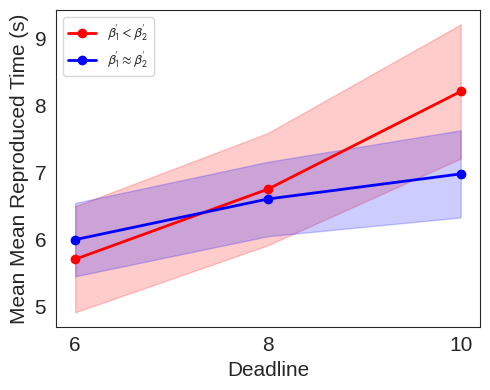

In [32]:
fontsize = 15

# Means and standard deviations for Group 1
mean_means_repro_t_group_1 = [np.mean(means_repro_t_deadline_6_group_1), 
                              np.mean(means_repro_t_deadline_8_group_1),
                              np.mean(means_repro_t_deadline_10_group_1)]
std_means_repro_t_group_1 = [standard_error(means_repro_t_deadline_6_group_1), 
                             standard_error(means_repro_t_deadline_8_group_1),
                             standard_error(means_repro_t_deadline_10_group_1)]

# Means and standard deviations for Group 2
mean_means_repro_t_group_2 = [np.mean(means_repro_t_deadline_6_group_2), 
                              np.mean(means_repro_t_deadline_8_group_2),
                              np.mean(means_repro_t_deadline_10_group_2)]
std_means_repro_t_group_2 = [standard_error(means_repro_t_deadline_6_group_2), 
                             standard_error(means_repro_t_deadline_8_group_2),
                             standard_error(means_repro_t_deadline_10_group_2)]

# X-axis positions
x = np.array([6, 8, 10])  # Deadlines

# Create the plot
fig, ax = plt.subplots(figsize=(5, 4))

# Plot Group 1 with shadow
ax.plot(x, mean_means_repro_t_group_1, label=r"$\beta_{1}^{\prime}<\beta_{2}^{\prime}$", color='red', marker='o', linewidth=2)
ax.fill_between(x, 
                np.array(mean_means_repro_t_group_1) - np.array(std_means_repro_t_group_1), 
                np.array(mean_means_repro_t_group_1) + np.array(std_means_repro_t_group_1), 
                color='red', alpha=0.2)

# Plot Group 2 with shadow
ax.plot(x, mean_means_repro_t_group_2, label=r"$\beta_{1}^{\prime} \approx \beta_{2}^{\prime}$", color='blue', marker='o', linewidth=2)
ax.fill_between(x, 
                np.array(mean_means_repro_t_group_2) - np.array(std_means_repro_t_group_2), 
                np.array(mean_means_repro_t_group_2) + np.array(std_means_repro_t_group_2), 
                color='blue', alpha=0.2)

# Add labels and legend
ax.set_xlabel('Deadline', fontsize = fontsize)
ax.set_ylabel('Mean Mean Reproduced Time (s)', fontsize = fontsize)
ax.set_xticks(x)
ax.set_xticklabels(['6', '8', '10'], fontsize = fontsize)

#ax.legend()

# Show the plot
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()

plt.legend()

#plt.savefig('../figures/mean_means_reproduced_times.png', dpi=200)
plt.show()

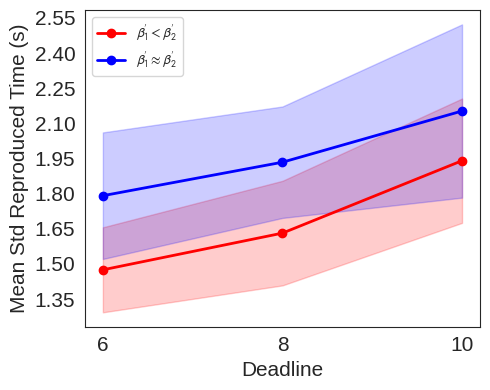

In [33]:


# Means and standard deviations for Group 1
mean_stds_repro_t_group_1 = [np.mean(stds_repro_t_deadline_6_group_1), 
                             np.mean(stds_repro_t_deadline_8_group_1),
                             np.mean(stds_repro_t_deadline_10_group_1)]
std_stds_repro_t_group_1 = [standard_error(stds_repro_t_deadline_6_group_1), 
                            standard_error(stds_repro_t_deadline_8_group_1),
                            standard_error(stds_repro_t_deadline_10_group_1)
                           ]

# Means and standard deviations for Group 2
mean_stds_repro_t_group_2 = [np.mean(stds_repro_t_deadline_6_group_2), 
                             np.mean(stds_repro_t_deadline_8_group_2),
                             np.mean(stds_repro_t_deadline_10_group_2)]
std_stds_repro_t_group_2 = [standard_error(stds_repro_t_deadline_6_group_2), 
                            standard_error(stds_repro_t_deadline_8_group_2),
                            standard_error(stds_repro_t_deadline_10_group_2)
                           ]

# X-axis positions
x = np.array([6, 8, 10])  # Deadlines

# Create the plot
fig, ax = plt.subplots(figsize=(5, 4))

# Plot Group 1 with shadow
ax.plot(x, mean_stds_repro_t_group_1, label=r"$\beta_{1}^{\prime}<\beta_{2}^{\prime}$", color='red', marker='o', linewidth=2)
ax.fill_between(x, 
                np.array(mean_stds_repro_t_group_1) - np.array(std_stds_repro_t_group_1), 
                np.array(mean_stds_repro_t_group_1) + np.array(std_stds_repro_t_group_1), 
                color='red', alpha=0.2)

# Plot Group 2 with shadow
ax.plot(x, mean_stds_repro_t_group_2, label=r"$\beta_{1}^{\prime} \approx \beta_{2}^{\prime}$", color='blue', marker='o', linewidth=2)
ax.fill_between(x, 
                np.array(mean_stds_repro_t_group_2) - np.array(std_stds_repro_t_group_2), 
                np.array(mean_stds_repro_t_group_2) + np.array(std_stds_repro_t_group_2), 
                color='blue', alpha=0.2)



ax.set_xlabel('Deadline', fontsize = fontsize)
ax.set_ylabel('Mean Std Reproduced Time (s)', fontsize = fontsize)
ax.set_xticks(x)
ax.set_xticklabels(['6', '8', '10'], fontsize = fontsize)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()

plt.legend()

plt.savefig('../figures/mean_stds_reproduced_times.png', dpi=200)
plt.show()


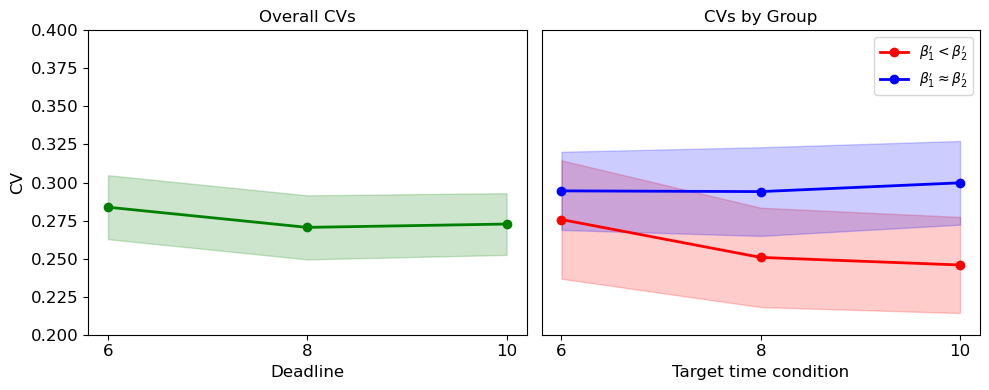

In [14]:
par_CVs_deadline_6 = []
par_CVs_deadline_8 = []
par_CVs_deadline_10 = []


for par in par_ids:

    df_par = df_processed_experiment_data[df_processed_experiment_data['ParticipantID']==par]
    
    df_par_deadline_6 = df_par[(df_par['GambleFinalDeadline']==6) & 
                                (df_par['MissedMaxDeadline']==0) #&
                           
                                    
    ]
    
    df_par_deadline_8 = df_par[(df_par['GambleFinalDeadline']==8) & 
                                (df_par['MissedMaxDeadline']==0) #&
                         
    ]
    
    df_par_deadline_10 = df_par[(df_par['GambleFinalDeadline']==10) & 
                                (df_par['MissedMaxDeadline']==0) #&
                                       
    ]
    
    par_CVs_deadline_6.append(np.std(df_par_deadline_6['ReproducedTime'].values)/np.mean(df_par_deadline_6['ReproducedTime'].values))
    par_CVs_deadline_8.append(np.std(df_par_deadline_8['ReproducedTime'].values)/np.mean(df_par_deadline_8['ReproducedTime'].values))
    par_CVs_deadline_10.append(np.std(df_par_deadline_10['ReproducedTime'].values)/np.mean(df_par_deadline_10['ReproducedTime'].values))

    

# Means of CV across participant for deadline 6
mean_CVs = [np.mean(par_CVs_deadline_6), np.mean(par_CVs_deadline_8), np.mean(par_CVs_deadline_10)]

# sems of CV across participant for deadline 6
sem_CVs = [standard_error(par_CVs_deadline_6), 
           standard_error(par_CVs_deadline_8),
           standard_error(par_CVs_deadline_10)
          ]



par_CVs_deadline_6_group_1 = []
par_CVs_deadline_8_group_1 = []
par_CVs_deadline_10_group_1 = []

par_CVs_deadline_6_group_2 = []
par_CVs_deadline_8_group_2 = []
par_CVs_deadline_10_group_2 = []

for par in par_ids:

    
    df_par = df_processed_experiment_data[df_processed_experiment_data['ParticipantID']==par]

    df_par_deadline_6 = df_par[(df_par['GambleFinalDeadline']==6) & 
                                (df_par['MissedMaxDeadline']==0)
    ]

    df_par_deadline_8 = df_par[(df_par['GambleFinalDeadline']==8) & 
                                (df_par['MissedMaxDeadline']==0)
    ]

    df_par_deadline_10 = df_par[(df_par['GambleFinalDeadline']==10) & 
                                (df_par['MissedMaxDeadline']==0)
    ]

    if par in par_ids_negative_delta_par:  
        
        par_CVs_deadline_6_group_1.append(np.std(df_par_deadline_6['ReproducedTime'])/np.mean(df_par_deadline_6['ReproducedTime']))
        par_CVs_deadline_8_group_1.append(np.std(df_par_deadline_8['ReproducedTime'])/np.mean(df_par_deadline_8['ReproducedTime']))
        par_CVs_deadline_10_group_1.append(np.std(df_par_deadline_10['ReproducedTime'])/np.mean(df_par_deadline_10['ReproducedTime']))
        
    else:
        if par not in par_ids_positive_delta_par: 
            par_CVs_deadline_6_group_2.append(np.std(df_par_deadline_6['ReproducedTime'])/np.mean(df_par_deadline_6['ReproducedTime']))
            par_CVs_deadline_8_group_2.append(np.std(df_par_deadline_8['ReproducedTime'])/np.mean(df_par_deadline_8['ReproducedTime']))
            par_CVs_deadline_10_group_2.append(np.std(df_par_deadline_10['ReproducedTime'])/np.mean(df_par_deadline_10['ReproducedTime']))

# Means and standard deviations for Group 1
mean_CVs_group_1 = [np.mean(par_CVs_deadline_6_group_1), np.mean(par_CVs_deadline_8_group_1), np.mean(par_CVs_deadline_10_group_1)]
sem_CVs_group_1 = [standard_error(par_CVs_deadline_6_group_1), 
                   standard_error(par_CVs_deadline_8_group_1), 
                   standard_error(par_CVs_deadline_10_group_1)]

# Means and standard deviations for Group 2
mean_CVs_group_2 = [np.mean(par_CVs_deadline_6_group_2), np.mean(par_CVs_deadline_8_group_2), np.mean(par_CVs_deadline_10_group_2)]
sem_CVs_group_2 = [standard_error(par_CVs_deadline_6_group_2), 
                   standard_error(par_CVs_deadline_8_group_2), 
                   standard_error(par_CVs_deadline_10_group_2)]


fontsize = 12

# X-axis positions
x = np.array([6, 8, 10])  # Deadlines

# Create the figure and axes for two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

### ---- First Plot ---- ###
axes[0].plot(x, mean_CVs, color='green', marker='o', linewidth=2)
axes[0].fill_between(x, 
                     np.array(mean_CVs) - np.array(sem_CVs), 
                     np.array(mean_CVs) + np.array(sem_CVs), 
                     color='green', alpha=0.2)

axes[0].set_xlabel('Deadline', fontsize=fontsize)
axes[0].set_ylabel('CV', fontsize=fontsize)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['6', '8', '10'], fontsize=fontsize)
axes[0].set_title('Overall CVs', fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

### ---- Second Plot (Group 1 & 2) ---- ###
axes[1].plot(x, mean_CVs_group_1, label=r"$\beta_{1}^{\prime}<\beta_{2}^{\prime}$", color='red', marker='o', linewidth=2)
axes[1].fill_between(x, 
                     np.array(mean_CVs_group_1) - np.array(sem_CVs_group_1), 
                     np.array(mean_CVs_group_1) + np.array(sem_CVs_group_1), 
                     color='red', alpha=0.2)

axes[1].plot(x, mean_CVs_group_2, label=r"$\beta_{1}^{\prime} \approx \beta_{2}^{\prime}$", color='blue', marker='o', linewidth=2)
axes[1].fill_between(x, 
                     np.array(mean_CVs_group_2) - np.array(sem_CVs_group_2), 
                     np.array(mean_CVs_group_2) + np.array(sem_CVs_group_2), 
                     color='blue', alpha=0.2)

axes[1].set_xlabel('Target time condition', fontsize=fontsize)
#axes[1].set_ylabel('CV', fontsize=fontsize)
axes[1].tick_params(left=False, labelleft=False)

axes[1].set_xticks(x)
axes[1].set_xticklabels(['6', '8', '10'], fontsize=fontsize)
axes[1].set_title('CVs by Group', fontsize=fontsize)
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
axes[1].legend()


axes[0].set_ylim(0.2, 0.4)
axes[1].set_ylim(0.2, 0.4)

# Adjust layout
plt.tight_layout()

plt.show()


=== sample ===
n = 21
Shapiro–Wilk: W=0.8810, p=0.01524 -> reject normality (alpha=0.05)
D’Agostino–Pearson: K2=3.7178, p=0.1558 -> fail to reject normality (alpha=0.05)
Anderson–Darling: A2=0.9681. At ~5.0% level: critical=0.6940 -> reject normality


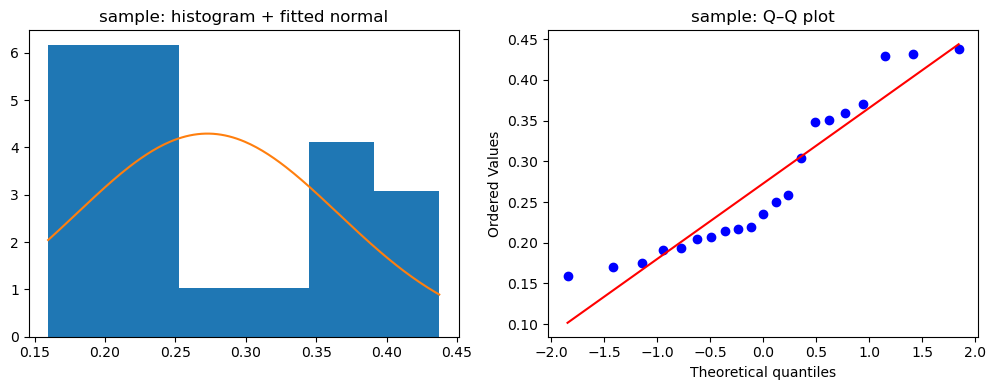

In [17]:
normality_report(par_CVs_deadline_10, name="sample", alpha=0.05, make_plots=True)

In [35]:
stat_deadline_6, p_deadline_6 = shapiro(par_CVs_deadline_6)
stat_deadline_8, p_deadline_8 = shapiro(par_CVs_deadline_8)
stat_deadline_10, p_deadline_10 = shapiro(par_CVs_deadline_10)
print(stat_deadline_6, p_deadline_6)
print(stat_deadline_8, p_deadline_8)
print(stat_deadline_10, p_deadline_10)

0.8995104000940639 0.03423672279600584
0.9007724280007299 0.036221191669780634
0.8809931640438062 0.015240006290752011


In [64]:
stat, p = friedmanchisquare(par_CVs_deadline_6,
                            par_CVs_deadline_8,
                            par_CVs_deadline_10)
print(f"Overall Friedman chi2 for CV as a function of Target time condition: {stat:.3f}, p = {p:.3g}")

pairs = [
    ("6 vs 8", par_CVs_deadline_6, par_CVs_deadline_8),
    ("6 vs 10", par_CVs_deadline_6, par_CVs_deadline_10),
    ("8 vs 10", par_CVs_deadline_8, par_CVs_deadline_10),
]

names = []
pvals = []
for name, a, b in pairs:
    stat, p = wilcoxon(a, b)
    names.append(name)
    pvals.append(p)

# Multiple-comparison correction
rej, pvals_corr = smm.multipletests(pvals, method="holm")[:2]

for name, p_raw, p_cor, r in zip(names, pvals, pvals_corr, rej):
    print(f"{name}: raw p = {p_raw:.3g}, Holm p = {p_cor:.3g}, significant = {r}")



Overall Friedman chi2 for CV as a function of Target time condition: 1.143, p = 0.565
6 vs 8: raw p = 0.257, Holm p = 0.772, significant = False
6 vs 10: raw p = 0.473, Holm p = 0.947, significant = False
8 vs 10: raw p = 0.919, Holm p = 0.947, significant = False


In [37]:
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(par_CVs_deadline_6_group_2,
                            par_CVs_deadline_8_group_2,
                            par_CVs_deadline_10_group_2)

print(f"Friedman chi2 for CV as a function of Target time condition, for group where beta_1_prime = beta_2_prime : {stat:.3f}, p = {p:.3g}")

Friedman chi2 for CV as a function of Target time condition, for group where beta_1_prime = beta_2_prime : 0.182, p = 0.913


In [38]:
stat, p = friedmanchisquare(par_CVs_deadline_6_group_1,
                            par_CVs_deadline_8_group_1,
                            par_CVs_deadline_10_group_1)


pairs = [
    ("6 vs 8", par_CVs_deadline_6_group_1, par_CVs_deadline_8_group_1),
    ("6 vs 10", par_CVs_deadline_6_group_1, par_CVs_deadline_10_group_1),
    ("8 vs 10", par_CVs_deadline_8_group_1, par_CVs_deadline_10_group_1),
]

names = []
pvals = []
for name, a, b in pairs:
    stat, p = wilcoxon(a, b)
    names.append(name)
    pvals.append(p)

# Multiple-comparison correction
rej, pvals_corr = smm.multipletests(pvals, method="holm")[:2]

for name, p_raw, p_cor, r in zip(names, pvals, pvals_corr, rej):
    print(f"{name}: raw p = {p_raw:.3g}, Holm p = {p_cor:.3g}, significant = {r}")

print(f"Friedman chi2 for CV as a function of Target time condition, for group where beta_1_prime < beta_2_prime : {stat:.3f}, p = {p:.3g}")

6 vs 8: raw p = 0.301, Holm p = 0.75, significant = False
6 vs 10: raw p = 0.25, Holm p = 0.75, significant = False
8 vs 10: raw p = 0.496, Holm p = 0.75, significant = False
Friedman chi2 for CV as a function of Target time condition, for group where beta_1_prime < beta_2_prime : 16.000, p = 0.496


/tmp/ipykernel_614/3145632734.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_b.boxplot(


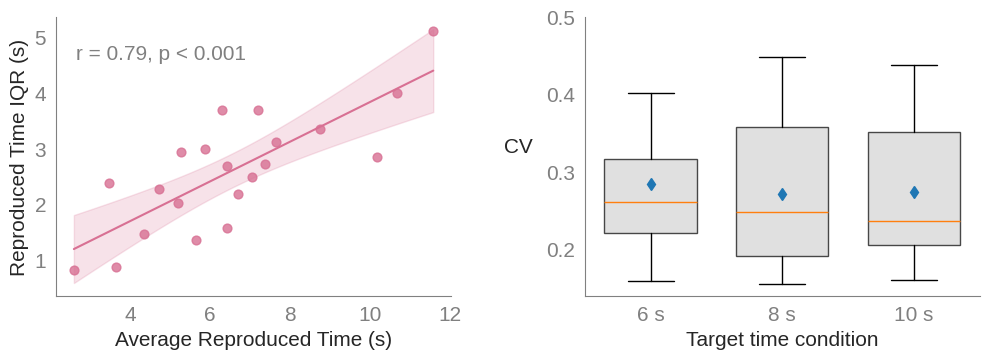

In [63]:
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

fontsize = 20

# Helper for significance bars
def add_sig_bar(ax, x1, x2, y, h, text, color="grey"):
    """
    Draw a significance bar with text between two boxplot positions.
    x1, x2: x positions (e.g. 1 and 2)
    y: baseline height
    h: bar height
    text: significance label, e.g. '***'
    """
    ax.plot(
        [x1, x1, x2, x2],
        [y,  y + h, y + h, y],
        lw=1.5,
        c=color
    )
    ax.text(
        (x1 + x2) / 2,
        y + h,
        text,
        ha='center',
        va='bottom',
        color=color,
        fontsize=fontsize
    )

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 3.7))

# ------------------------------------------------------------------
# LEFT PANEL: correlation + regression line + CI
# ------------------------------------------------------------------
ax = ax_left

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color("grey")
ax.spines['left'].set_color("grey")

ax.tick_params(axis='both', which='major', labelsize=15, colors="grey")

x = np.asarray(average_repro)
y = np.asarray(IQR_repro_ts)

corr_coefficient, p_value = pearsonr(x, y)

slope, intercept = np.polyfit(x, y, 1)
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = slope * x_fit + intercept

n = x.size
y_hat = slope * x + intercept
residuals = y - y_hat
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))

x_mean = np.mean(x)
Sxx = np.sum((x - x_mean)**2)
t_val = t.ppf(1 - 0.025, df=n - 2)

se_fit = s_err * np.sqrt(1/n + (x_fit - x_mean)**2 / Sxx)
ci_upper = y_fit + t_val * se_fit
ci_lower = y_fit - t_val * se_fit

ax.scatter(x, y,
           label='Data',
           color="#d87093",
           s=40,
           alpha=0.8)

ax.plot(x_fit, y_fit, color='#d87093', label='Best fit line')
ax.fill_between(x_fit, ci_lower, ci_upper, color="#d87093", alpha=0.2, label='95% CI')

ax.set_xlabel("Average Reproduced Time (s)", fontsize=15)
ax.set_ylabel("Reproduced Time IQR (s)", fontsize=15)

for tick_label in ax.get_xticklabels() + ax.get_yticklabels():
    tick_label.set_color("grey")

if p_value < 0.0001:
    text_str = f'r = {corr_coefficient:.2f}, p < 0.001'
else:
    text_str = f'r = {corr_coefficient:.2f}, p = {p_value:.3f}'

ax.text(
    0.05, 0.9, text_str,
    transform=ax.transAxes,
    fontsize=15,
    verticalalignment='top',
    color="grey"
)

# ------------------------------------------------------------------
# RIGHT PANEL: boxplots of CV by deadline + MEANS + SIGNIFICANCE BARS
# ------------------------------------------------------------------
ax_b = ax_right

ax_b.spines['top'].set_visible(False)
ax_b.spines['right'].set_visible(False)
ax_b.spines['bottom'].set_color("grey")
ax_b.spines['left'].set_color("grey")

ax_b.tick_params(axis='both', which='major', labelsize=15, colors="grey")

data = [par_CVs_deadline_6, par_CVs_deadline_8, par_CVs_deadline_10]
labels = ['6 s', '8 s', '10 s']

bp = ax_b.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    showmeans=True,
    widths=0.7,
    meanprops=dict(
        marker='d',
        markerfacecolor='C0',
        markeredgecolor='C0',
        markersize=6
    ),
    showfliers=False
)

for box in bp['boxes']:
    box.set(facecolor='lightgrey', alpha=0.7)

ax_b.set_xlabel('Target time condition', fontsize=15)
ax_b.set_ylabel('CV', fontsize=15, rotation=0, labelpad=20)

for tick_label in ax_b.get_xticklabels() + ax_b.get_yticklabels():
    tick_label.set_color("grey")

# ---- SIGNIFICANCE BARS (all p < 0.001) ----
y_max = max(
    np.max(par_CVs_deadline_6),
    np.max(par_CVs_deadline_8),
    np.max(par_CVs_deadline_10)
)

h = 0.02  # height of each bar

# 6 s vs 8 s  (positions 1 and 2)
#add_sig_bar(ax_b, 1, 2, y=y_max - 0.09, h=h, text='***')

# 8 s vs 10 s (positions 2 and 3)
#add_sig_bar(ax_b, 2, 3, y=y_max - 0.04, h=h, text='***')

# 6 s vs 10 s (positions 1 and 3)
#add_sig_bar(ax_b, 1, 3, y=y_max + 0.03, h=h, text='***')

# Make sure bars aren't cut off
ax_b.set_ylim(top=0.5)

plt.tight_layout(w_pad=3)
#plt.savefig("../figures/cv_plots.svg", format="svg", bbox_inches="tight")
plt.show()
